(100, 452, 452)


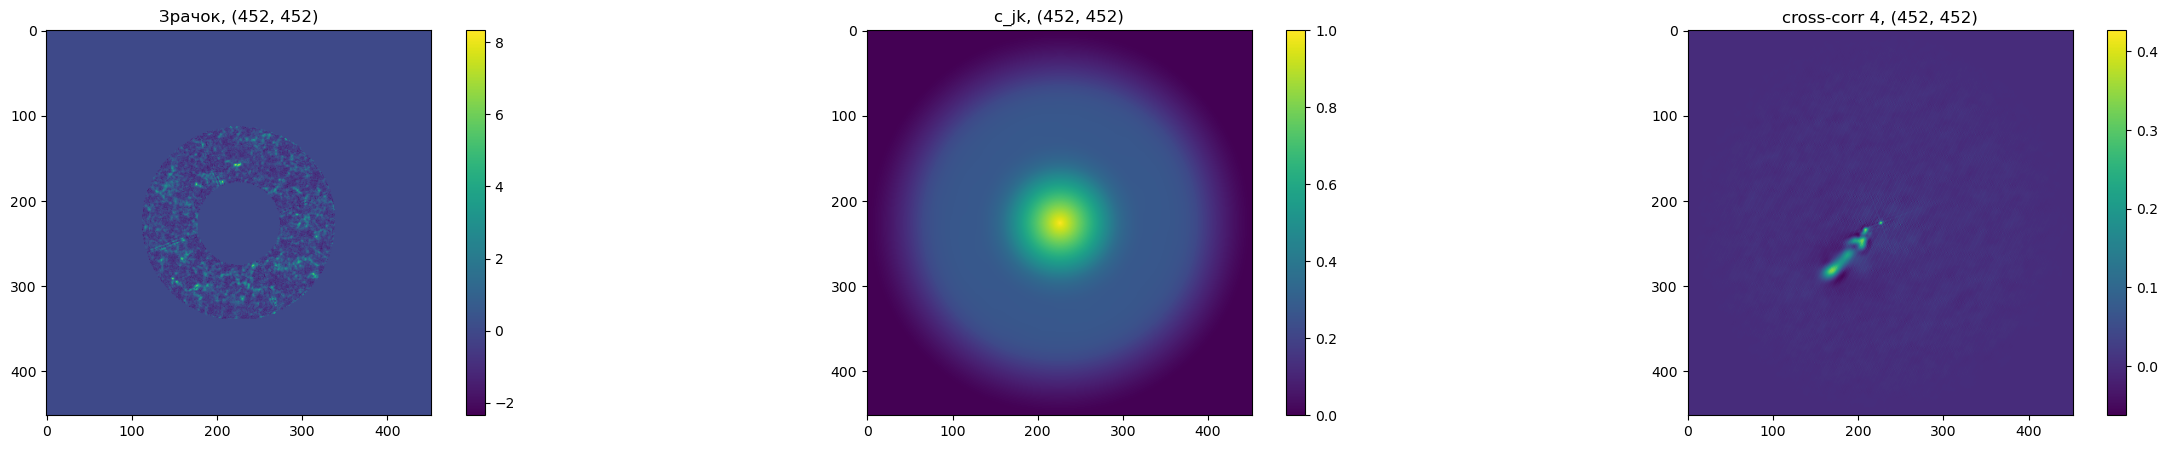

In [37]:
import time
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import shift
from scipy.optimize import curve_fit
from IPython.display import clear_output
from bisect import bisect_left

def take_closest(myList, myNumber):
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return 0, 1
    if pos == len(myList):
        return -2, -1
    if pos != 0:
        before = myList[pos - 1]
        after = myList[pos]
        return np.argwhere(myList==after)[0][0], np.argwhere(myList==before)[0][0]

def c_jk(data):
    nx = data.shape[0] # ширина окна для автокорреляции зрачка (должно быть минимум в 2 раза больше, чем ширина зрачка)
    I0c = (data != 0) * int(1)
    res = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(I0c)*np.fft.fft2(I0c).conjugate())))
    res /= np.max(res)
    return res, nx

def gamma_poly_se(X, Y, Vx, Vy, z):
    global cjk, t, a1, gammas, data, delta
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta
    
    res = gammas[take_closest(a1, z)[0]] + (z - a1[take_closest(a1, z)[0]]) * \
        ((gammas[take_closest(a1, z)[1]] - gammas[take_closest(a1, z)[0]])/ \
         (a1[take_closest(a1, z)[1]] - a1[take_closest(a1, z)[0]]))

    res = shift(res, (-Ypix, Xpix), order=1) 
    
    res = res * cjk
    
    k = np.max(data[data.shape[0]//2-int(Ypix)-1:data.shape[0]//2-int(Ypix)+2, 
                    data.shape[1]//2+int(Xpix)-1:data.shape[1]//2+int(Xpix)+2]) / np.max(res)
    
#     print(np.max(res))
    res = res * k
    return res, k

# ----------- входные параметры
D = 2.5
latency = 4
sec_per_frame = 0.01
t = sec_per_frame * latency

lambda_=500*pow(10, -9) # нм
k = 2*np.pi/lambda_

# ---------- считывание зрачка и картины мерцаний
pupil = np.loadtxt('C:/astro/domecam/frame.gz')
data = np.loadtxt('C:/astro/domecam/data_corr4.gz')
pupil_pix = pupil.shape[0]//2 # Диаметр зрачка в пикселях

# ------------ шаг для функции гамма
x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
X, Y = np.meshgrid(x, y)

# ------------- c_jk
cjk, nx = c_jk(pupil)
f_scale = pupil_pix/(D*nx)
delta = D/pupil_pix 

# -------------- гаммы
gammas = np.load(f'C:/astro/domecam/gammas.npy')
# gammas = np.load(f'C:/astro/domecam/gammas0_5.npy')
print(gammas.shape)

# ------------------ распределение гамм
a1 = 3*np.logspace(2.824, 4, num=100, base=10)
a1[0]=2000

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 5))

fig.colorbar(ax.imshow(pupil), ax = ax)
ax.grid(False)
ax.set_title(f'Зрачок, {pupil.shape}')

fig.colorbar(ax2.imshow(cjk), ax=ax2)
ax2.grid(False)
ax2.set_title(f'c_jk, {cjk.shape}')

fig.colorbar(ax3.imshow(data), ax=ax3)
ax3.grid(False)
ax3.set_title(f'cross-corr 4, {data.shape}')

def CLEAN(dirty, gain=None, thresh=None, niter=None):
    global sec_per_frame, latency, delta
    """
    Hogbom clean, https://www.mrao.cam.ac.uk/~bn204/alma/python-clean.html

    :dirty: Изображение, подлежащее деконволюции
    :gain: Коэффициент усиления, т.е. доля самого яркого пикселя, которая удаляется на каждой итерации
    :thresh: Алгоритм прекращается при достижении максимального абсолютного отклонения остатка меньше этого значения
    :niter: Максимальное количество итераций, который необходимо провести, если пороговое значение "thresh" не достигнуто
    """
    comps=np.zeros(dirty.shape)
    res=np.array(dirty) 
    window=np.ones(dirty.shape, np.bool)
    
    tmp = 0
    Cn2 = []
    z = []
    vx = []
    vy = []

    for i in range(niter):
        my, mx = np.unravel_index(np.argmax(res[window]), res.shape) # fabs? # нахождение максимального значения
        mval=res[my, mx]*gain
        comps[my, mx]+=mval
        
        t = sec_per_frame * latency
        Vy = (dirty.shape[0]//2-my)*delta/t
        Vx = -(dirty.shape[1]//2-mx)*delta/t
     
        if int(Vx) == 0 and int(Vy) == 0:
            myParams = [(Vx, Vy, 2000)]
        else:
            myParams = [(Vx, Vy, 10000)]
            
        psf, speckle_x, speckle_y, Cn2v, zv, vxv, vyv = multi_speckle_fit(params=myParams, ydata=res)
        Cn2.append(Cn2v*gain)
        z.append(zv)
        vx.append(vxv)
        vy.append(vyv)
        
        res -= psf*gain
    
        tmp+=1
        if np.max(np.fabs(res)) < thresh: 
            print('Thresh reached!')
            break
    print('Total interations:', tmp)
    with open('C:/astro/domecam/model_res.txt', 'a') as f:
        print(f'gain={gain}, thresh={thresh}, niter={tmp}, RMS={np.mean((dirty-res)**2)}', file=f)
    
    return comps, res, Cn2, z, vx, vy


def multi_speckle_fit(params=None, ydata=None):
    global xdata, sec_per_frame, latency, delta
    def speckle_fit(xcoord, ycoord, z_dist, ydata): # аппроксимация одного слоя
#         k=30
        def _g(M, *args): # обходной способ, именно эту функцию будем аппроксимировать
            x, y = M
            arr = np.zeros(x.shape)
            for i in range(len(args)//3):
#                 arr += (gamma_poly_se(x, y, *args[i*3:i*3+3])[0])[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k].ravel()
                arr += (gamma_poly_se(x, y, *args[i*3:i*3+3])[0]).ravel()
            return arr
        
        params = [(xcoord, ycoord, z_dist)] # подгонка типа ввода параметров под функцию
        p0 = [p for prms in params for p in prms]
        
        st=time.perf_counter()
        
        cr = ydata.shape[0]//2, ydata.shape[1]//2
        t = sec_per_frame * latency
        Xpix1 = int(xcoord*t/delta) + cr[1]
        Ypix1 = -int(ycoord*t/delta) + cr[0]
                
#         ydata = ydata[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k]

        
        x = np.linspace(-ydata.shape[1]//2, ydata.shape[1]//2-1, ydata.shape[1])
        y = np.linspace(-ydata.shape[0]//2, ydata.shape[0]//2-1, ydata.shape[0])
        X, Y = np.meshgrid(x, y)

        fit = np.zeros(X.shape) # результирующее изображение
        xdata = np.vstack((X.ravel(), Y.ravel())) # значения аргумента
        ydata = ydata.ravel()
        
        popt, pcov = curve_fit(_g, xdata, ydata, p0, bounds=[[xcoord-3, ycoord-3, 2000],
                                                             [xcoord+3, ycoord+3, np.inf]]) 
#         popt, pcov = curve_fit(_g, xdata, ydata, p0)
        print(f'Fitted parametrs: {popt[0]:.2f} {popt[1]:.2f} {popt[2]}')
        k_coeff=[]
        for i in range(len(popt)//3):
#             fit += (gamma_poly_se(X, Y, *popt[i*3:i*3+3])[0])[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k]
            fit += (gamma_poly_se(X, Y, *popt[i*3:i*3+3])[0])
            k_coeff.append(gamma_poly_se(X, Y, *popt[i*3:i*3+3])[1])

        print(f'Time: {time.perf_counter()-st:.4f}')
    
        t = sec_per_frame * latency
        Xpix = int(popt[0]*t/delta)
        Ypix = int(popt[1]*t/delta)
    
        return fit, Xpix, Ypix, k_coeff, popt[2], popt[0], popt[1]
    
    myParams = [p for prms in params for p in prms]
    res = np.zeros(data.shape)
    cr = data.shape[0]//2 # центр изображения
    Xc = []
    Yc = []
    t = sec_per_frame * latency

    for i in range(len(myParams)//3):
        print(f'Speckle fitting:', *myParams[i*3:i*3+3])
        fit, xcoord, ycoord, Cn2_fitted, zv, Vx, Vy = speckle_fit(*myParams[i*3:i*3+3], ydata)
#         res[(res.shape[0]//2 - ycoord) - fit.shape[0]//2:(res.shape[0]//2 - ycoord) + fit.shape[0]//2, 
#             (res.shape[1]//2 + xcoord) - fit.shape[1]//2:(res.shape[1]//2 + xcoord) + fit.shape[1]//2] += fit
        res +=fit
        Xc.append(xcoord)
        Yc.append(ycoord)

        print(f'-Cn2: {Cn2_fitted[0]*1e-13}')
        print(f'-max fitted value: {np.max(fit):.2f}')
        print(f'-max initial value: {np.max(data[cr-ycoord-4:cr-ycoord+4, cr+xcoord-4:cr+xcoord+4]):.2f}')
        print('')
    
    return res, Xc, Yc, Cn2_fitted[0]*1e-13, zv, Vx, Vy

def one_speckle_fit(params=None): # аппроксимация одного слоя
    global data
    k=30
    def _g(M, *args): # обходной способ, именно эту функцию будем аппроксимировать
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//3):
#             arr += (gamma_poly_se(x, y, *args[i*3:i*3+3])[0])[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k].ravel()
            arr += (gamma_poly_se(x, y, *args[i*3:i*3+3])[0]).ravel()
        return arr
        
    p0 = [p for prms in params for p in prms]
        
    st=time.perf_counter()
    
#     cr = ydata.shape[0]//2, ydata.shape[1]//2
#     t = sec_per_frame * latency
#     Xpix1 = int(xcoord*t/delta) + cr[1]
#     Ypix1 = -int(ycoord*t/delta) + cr[0]
                
#     ydata = ydata[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k]
        
    x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
    y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
    X, Y = np.meshgrid(x, y)

    fit = np.zeros(X.shape) # результирующее изображение
    xdata = np.vstack((X.ravel(), Y.ravel())) # значения аргумента
    ydata = data.ravel()
    
    print('xdata shape:', xdata.shape)
    bounds=[[-np.inf, -np.inf, 2000], [np.inf, np.inf, np.inf]]
    bounds = np.array(bounds)
    print(bounds.shape)
        
    popt, pcov = curve_fit(_g, xdata, ydata, p0, bounds=bounds)
    k_coeff=[]
    for i in range(len(popt)//3):
#         fit += (gamma_poly_se(X, Y, *popt[i*3:i*3+3])[0])[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k]
        fit += (gamma_poly_se(X, Y, *popt[i*3:i*3+3])[0])
        k_coeff.append(gamma_poly_se(X, Y, *popt[i*3:i*3+3])[1])

    print(f'Time: {time.perf_counter()-st:.4f}')
    
#     t = sec_per_frame * latency
#     Xpix = int(popt[0]*t/delta)
#     Ypix = int(popt[1]*t/delta)

    for i in range(len(popt)//3):
        print(*popt[i*3:i*3+3])

    k_coeff = np.array(k_coeff)
    return fit, popt, k_coeff*1e-13

xdata shape: (2, 204304)
(2, 3)
Time: 0.2541
0.0812019391570682 0.10775298863496574 2000.0000000000002


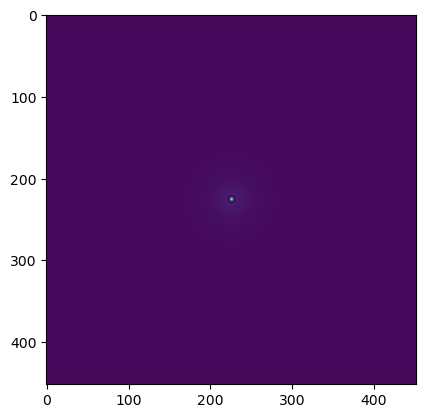

In [39]:
# myparams3 = [(0, 0, 2000), (-11, -11, 19000)]
myparams3 = [(0, 0, 2000)]
fit, popt, Cn2v = one_speckle_fit(params=myparams3)

plt.imshow(fit)

C:\Users\miron\AppData\Local\Temp\ipykernel_2768\1159341051.py:109: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  window=np.ones(dirty.shape, np.bool)


Speckle fitting: 0.0 0.0 2000
Fitted parametrs: 0.08 0.11 2000.0000000000002
Time: 0.3091
-Cn2: 3.648698671808651e-12
-max fitted value: 0.43
-max initial value: 0.43

Speckle fitting: -15.763274336283187 -15.486725663716813 10000
Fitted parametrs: -15.90 -15.35 39372.615501401764
Time: 0.6099
-Cn2: 6.14829091670266e-13
-max fitted value: 0.34
-max initial value: 0.34

Speckle fitting: -6.084070796460177 -6.084070796460177 10000
Fitted parametrs: -6.56 -6.24 22674.16165759295
Time: 0.6281
-Cn2: 4.4678913954543334e-13
-max fitted value: 0.34
-max initial value: 0.34

Speckle fitting: -4.977876106194691 -2.2123893805309733 10000
Fitted parametrs: -5.03 -2.61 6568.387265085891
Time: 0.5219
-Cn2: 1.120950800667108e-12
-max fitted value: 0.34
-max initial value: 0.34

Speckle fitting: -11.061946902654867 -10.508849557522124 10000
Fitted parametrs: -12.12 -11.98 61422.5623019713
Time: 0.7767
-Cn2: 1.860096848380691e-13
-max fitted value: 0.21
-max initial value: 0.23

Speckle fitting: -5.807

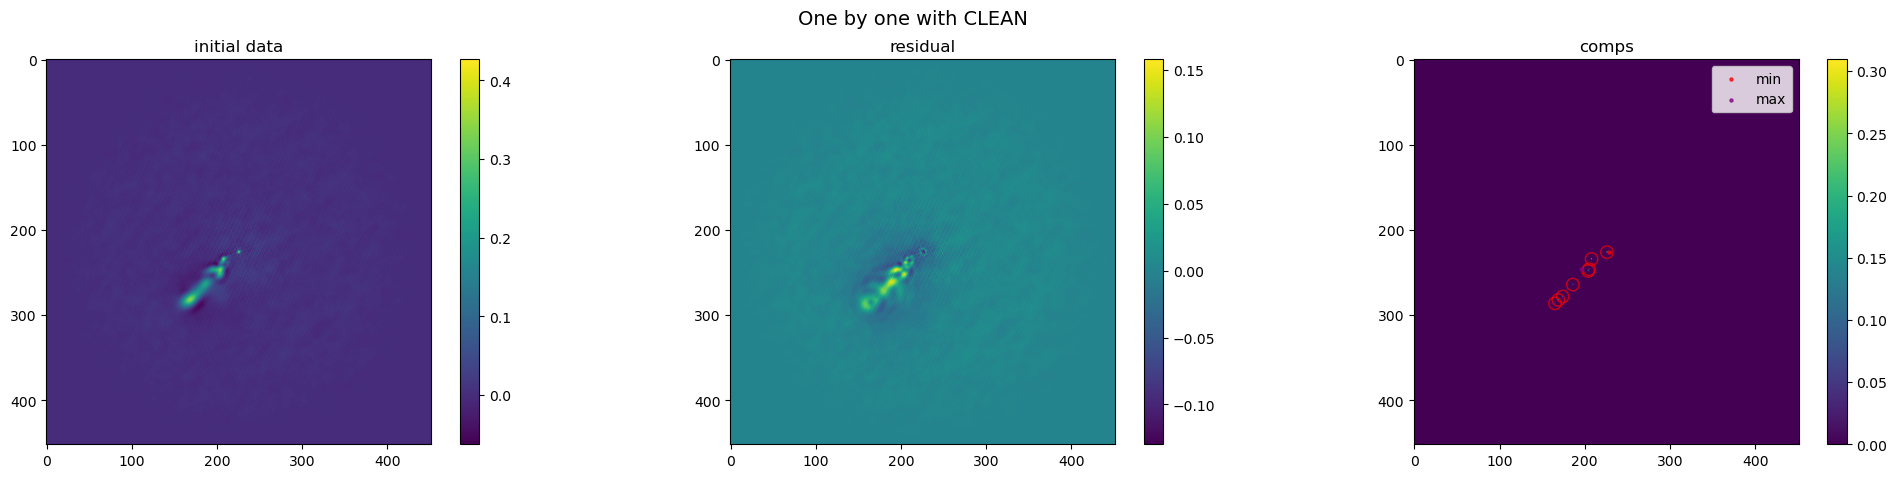

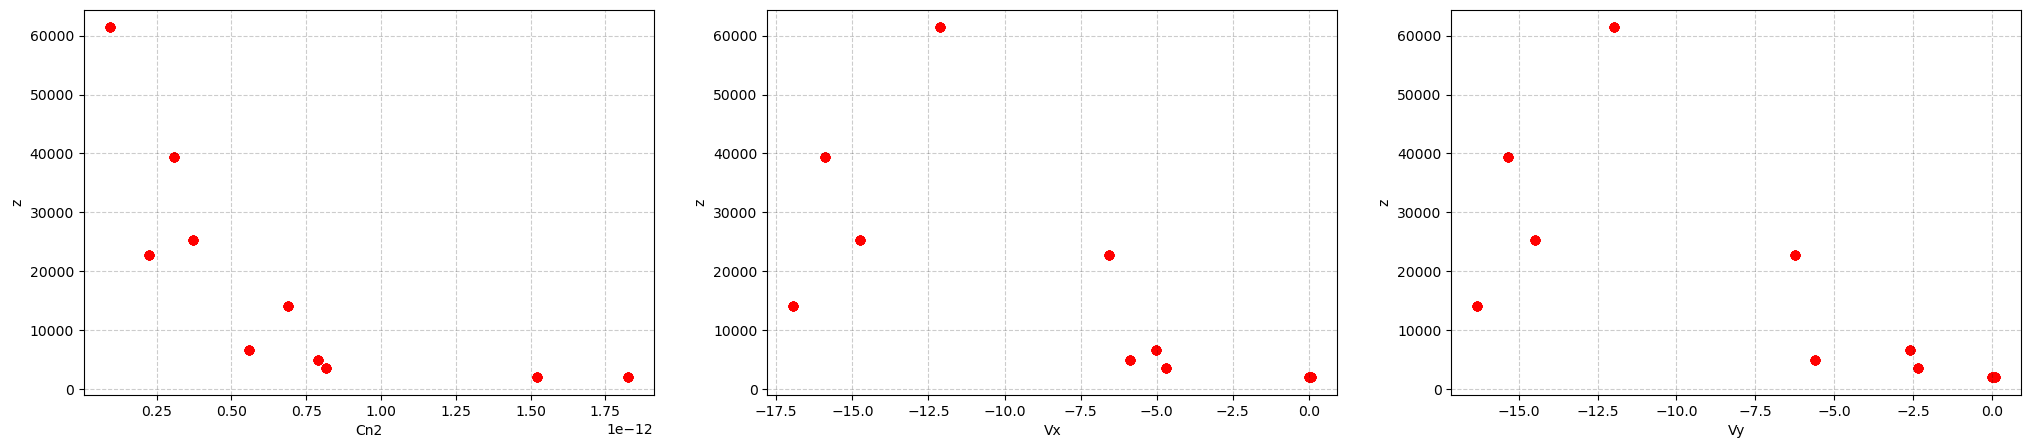

In [2]:
comps, residual, Cn2, z, vx, vy = CLEAN(data, gain=0.5, thresh=0.1, niter=10)

r0 = pow(0.423*pow(k, 2)*(np.sum(Cn2)), -3/5)
print(f'sum Cn2: {np.sum(Cn2)}')
print(f'r0, sm: {100*r0:.2f}')
print(f'seeing, arcsec: {0.98 * 206265 * lambda_/r0:.2f}')


fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
fig.colorbar(ax.imshow(data), ax=ax)
fig.colorbar(ax2.imshow(residual), ax=ax2)
fig.colorbar(ax3.imshow(comps), ax=ax3)
a_tmp = np.where(comps!=0)
for i in range(len(a_tmp[0])):
    ax3.scatter(a_tmp[1][i], a_tmp[0][i], alpha=0.7, s=80, facecolors='none', edgecolors='r')
ax.set_title('initial data')
ax2.set_title('residual')
ax3.set_title('comps')
ax3.scatter(np.unravel_index(np.argmin(residual), residual.shape)[1], 
            np.unravel_index(np.argmin(residual), residual.shape)[0], color='red', alpha=0.7, s=5, label='min')
ax3.scatter(np.unravel_index(np.argmax(residual), residual.shape)[1],
            np.unravel_index(np.argmax(residual), residual.shape)[0], color='purple', alpha=0.7, s=5, label='max')
ax3.legend()

print('min value fit:', np.min(residual), 'coords:', np.unravel_index(np.argmin(residual), residual.shape))
print('max value fit:', np.max(residual), 'coords:', np.unravel_index(np.argmax(residual), residual.shape))
print('centr value:', residual[226, 226])
fig.suptitle('One by one with CLEAN', fontsize=14)

z = np.round(z, 2)
profile1 = np.stack((z, Cn2))
profile1 = profile1[:, profile1[0].argsort()]
profile1[0, :] = np.round(profile1[0, :], 2)

allCn2=[]
tmp=0
for i in range(len(profile1[0])):
    if profile1[0][i] == 2000:
        tmp+=1
        allCn2.append(profile1[1][i])

print(f'dome turb counted {tmp} times: {np.sum(allCn2)}')

profile2 = np.stack((z, vx))
profile2 = profile2[:, profile2[0].argsort()]
profile2[0, :] = np.round(profile2[0, :], 2)

profile3 = np.stack((z, vy))
profile3 = profile3[:, profile3[0].argsort()]
profile3[0, :] = np.round(profile3[0, :], 2)

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))

for i in range(len(profile1[0])):
    ax.scatter(profile1[1], profile1[0], color='red')
    ax2.scatter(profile2[1], profile2[0], color='red')
    ax3.scatter(profile3[1], profile3[0], color='red')
    
ax.set_xlabel('Cn2')
ax.set_ylabel('z')
ax2.set_xlabel('Vx')
ax2.set_ylabel('z')
ax3.set_xlabel('Vy')
ax3.set_ylabel('z')
ax.grid(color = 'black', linestyle='--', alpha = 0.2)
ax2.grid(color = 'black', linestyle='--', alpha = 0.2)
ax3.grid(color = 'black', linestyle='--', alpha = 0.2)
print('')

Time: 38.0578
0.010586591098458682 0.005996540381331893 2144.44064397712
-16.01492562198926 -15.226290026019601 26282.367539144052
-6.698644560689586 -6.203790584559007 20619.634065516268
-4.766165734648279 -2.773526598602376 6636.404379007016
-11.747588205524513 -11.600901175062619 37646.5024398817
-5.530973155958623 -5.23741389745671 3400.6224834568256
-14.095227260298994 -14.0593014316066 20787.18829454157
-0.2862924640807198 -0.27717949599452923 1081.889486207507
-4.965914629213195 -1.9304190546681113 2065.5285805682524
-16.94146963862256 -16.387705082225892 12532.165467598403
min value fit: -0.4912712562786178 coords: (227, 225)
max value fit: 0.12136125327149108 coords: (247, 193)
centr value: -0.19119316649438178


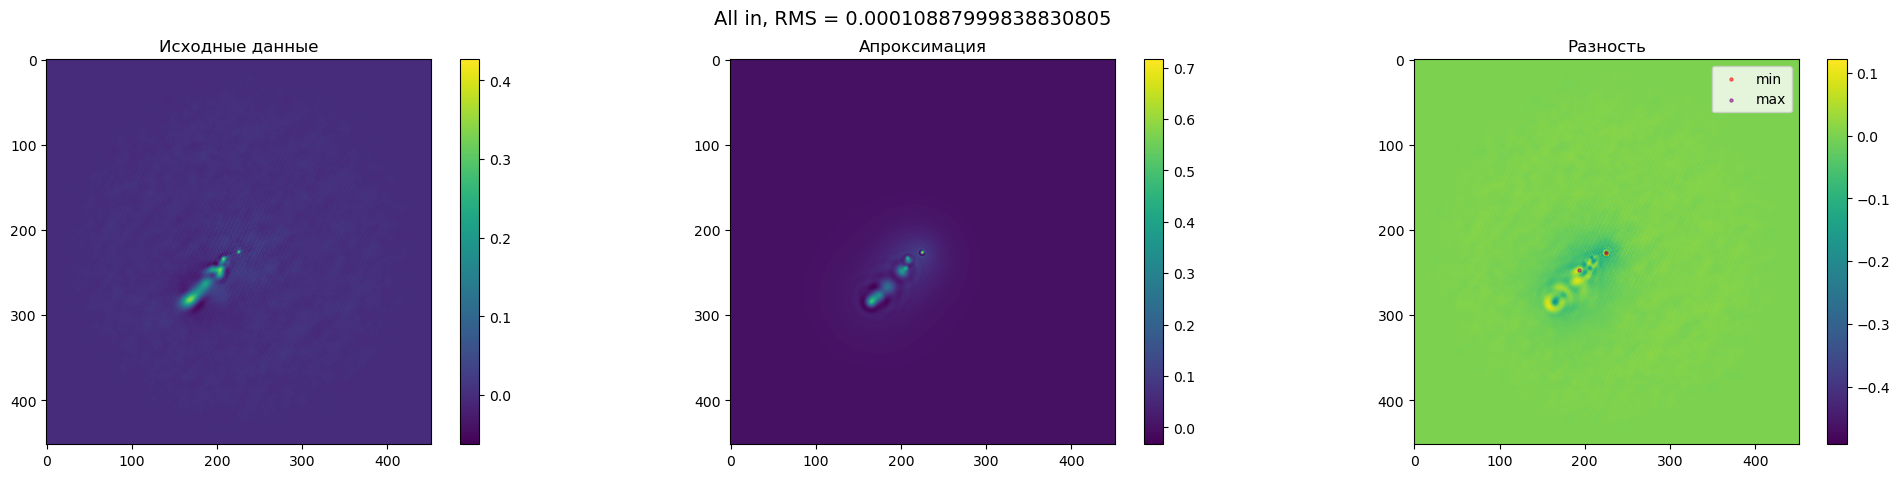

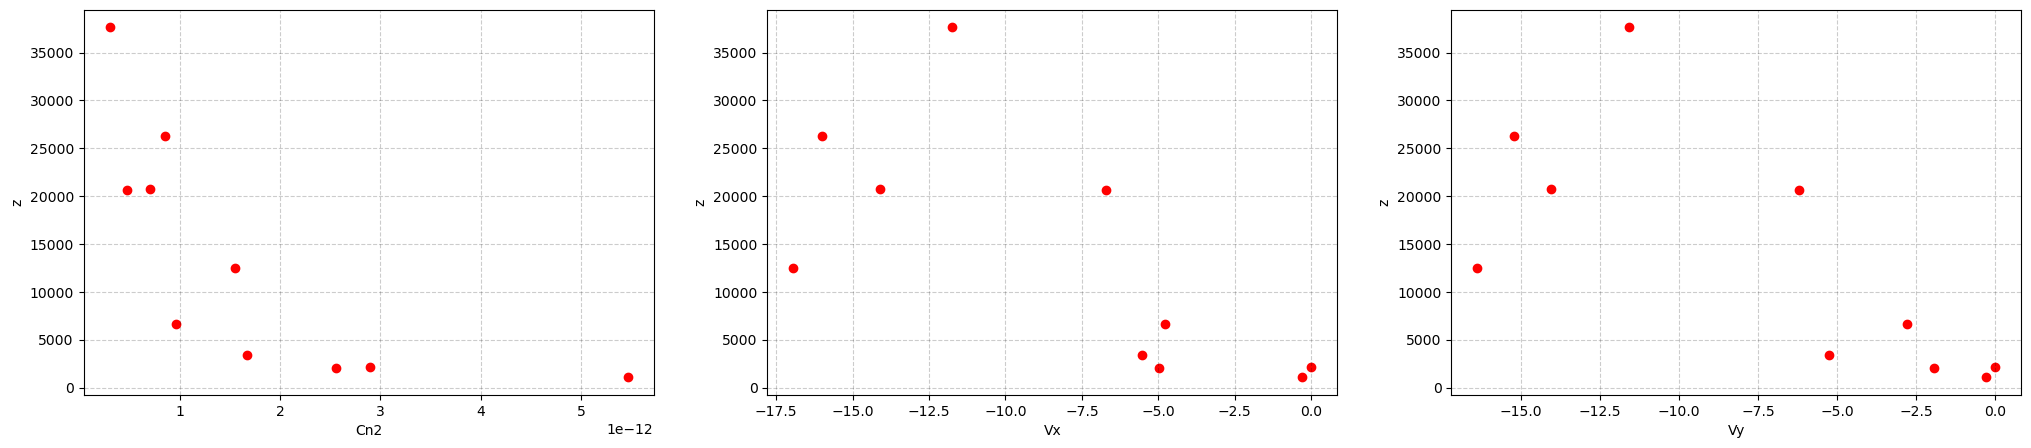

In [3]:
myparams = np.stack((vx, vy, z))
myparams2=[]
for i in range(len(myparams[0])):
    myparams2.append((myparams[0][i], myparams[1][i], myparams[2][i]))

fit, popt, Cn2v = one_speckle_fit(params=myparams2)
popt = np.round(popt, 2)
z=[]
vx=[]
vy=[]
for i in range(len(popt)//3):
    z.append(popt[3*i+2])
    vx.append(popt[3*i])
    vy.append(popt[3*i+1]) 

profile = np.stack((z, vx, vy))


fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
cr = data.shape[0]//2 # центр изображения

fig.colorbar(ax.imshow(data), ax=ax)
ax.set_title('Исходные данные')
fig.colorbar(ax2.imshow(fit), ax=ax2)
ax2.set_title('Апроксимация')
fig.colorbar(ax3.imshow(data-fit), ax=ax3)
ax3.set_title('Разность')
ax3.scatter(np.unravel_index(np.argmin(data-fit), (data-fit).shape)[1], 
            np.unravel_index(np.argmin(data-fit), (data-fit).shape)[0], color='red', alpha=0.5, s=5, label='min')
ax3.scatter(np.unravel_index(np.argmax(data-fit), (data-fit).shape)[1],
            np.unravel_index(np.argmax(data-fit), (data-fit).shape)[0], color='purple', alpha=0.5, s=5, label='max')
ax3.legend()
fig.suptitle(f'All in, RMS = {np.mean((data - fit)**2)}', fontsize=14)

fig, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(25, 5))

ax4.scatter(Cn2v, profile[0], color='red')
ax5.scatter(profile[1], profile[0], color='red')
ax6.scatter(profile[2], profile[0], color='red')
ax4.set_xlabel('Cn2')
ax4.set_ylabel('z')
ax5.set_xlabel('Vx')
ax5.set_ylabel('z')
ax6.set_xlabel('Vy')
ax6.set_ylabel('z')
ax4.grid(color = 'black', linestyle='--', alpha = 0.2)
ax5.grid(color = 'black', linestyle='--', alpha = 0.2)
ax6.grid(color = 'black', linestyle='--', alpha = 0.2)

print('min value fit:', np.min(data-fit), 'coords:', np.unravel_index(np.argmin(data-fit), (data-fit).shape))
print('max value fit:', np.max(data-fit), 'coords:', np.unravel_index(np.argmax(data-fit), (data-fit).shape))
print('centr value:', (data-fit)[226, 226])

In [4]:
# клин подходит не оч на большом кол-ве итерраций, т.к. он принимает остаточные маленькие пики за новые слои, в то время как
# они не принадлежат других слоям, а являются всего лишь остатками предыдуших

# маску не делать - Борис

# 1. попробовать передать в керв-фит сразу все начальные приближения
# 3. что если гамму вообще научиться сплющивать и поворачивать, чтобы подгонять ее под сам пик
# 4. что если к Оцу применять гамма-коррекцию, чтобы не так жестко обрезал